In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils import resample
from sklearn.model_selection import train_test_split

import missingno as mno

from category_encoders import BinaryEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
# from sklearn.neural_network import MLPClassifier

# from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import RandomizedSearchCV

import joblib

from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, classification_report

One of the major use cases of Urbint is to prevent damage caused by different types of construction on gas pipes. Important indicators for the risk of a construction project are the type of work being done (i.e. installing a pole is not as risky as installing a sewer) and topological information about where the construction is being done.This dataset contains tickets, where each ticket contains binary information if a certain work type was used (work type are given numerical numbers and not named to hide proprietary Urbint information),  topological information such as elevation and slope of elevation, the date the ticket was created and where there was damage. Your goal is to build a predictive model that will find whether there is an accident. One thing to watch out for is that it is a very unbalanced dataset so make sure to use techniques that will help with this. 

  

We truly appreciate your time investment and interest in this role. We believe this is a way for any candidate to shine without the pressures of an interview environment. We also don’t want to set any time limits so feel free to send us the slides and/or code, anytime before your first round of interviews. 


Ideal Slide would contain all these sections:

    Summary of problem statement - this helps you showcase your domain understanding and communication skills.
    Entire Solution space considered - to showcase your technical breadth.
    Subset of the solution space that you determined you would experiment with and reasoning behind your decisions.  - to showcase your technical depth and how fast you can narrow down the solution space. EDA and Viz skills.
    How you measure your model performance. - experiment design
    Final results. - communication skills


Time series train test split
- since this is time series data, the test set musn't be randomly sampled. 
- the test set will be the latter part of the dataset after it is arranged by time in ascending order 

Options for dealing with imbalance:
- downsample negatives (lose information)
- upsample positives (runtime too long since will have too high a number of both negatives and positives)
- use recall/balanced accuracy/f1 as the metric for judging model performance
- adjust class weights in classifiers (runtime too long since we have too many negatives)

Dealing with work type columns:
- cannot convert to ordinal values (a single integer column where 1=work type 1, 2=work type 2 and so on) because that implies an order to the values. But these work types have no order or hierarchy.
- one hotted column encoding is inefficient, specially if we use tree based models
- we will use binary encoding because it needs fewer columns than one hot encoding to encode the same information

Dealing with outliers:
- since we have relatively few positives, we will only remove outliers if they don't reduce the number of positives in the dataset.

Dealing with NAs:
- gas_main_hid10_total_length, gas_service_hid10_total_length have approx 25% missing values, we will use multiple imputation to handle them. We can use coordinates data to get reasonably accurate imputed values for these 2 columns

Feature engineering:
- engineer columns for month of year and day of week from datetime column. If there is a yearly/weekly seasonality in damaging events, this will help to identify it

Choice of model:
- a linear model is too trivial, this is a nonlinear problem, so we won't use them
- neural nets take too long to tune
- use tree based models - they perform best out of the box


In [2]:
data_raw = pd.read_csv("DS2.csv")

In [3]:
data_raw.shape

(3441356, 74)

In [4]:
data_raw.head()

,Unnamed: 0,work_type_0,work_type_1,work_type_2,work_type_3,work_type_4,work_type_5,work_type_6,work_type_7,work_type_8,...,work_type_63,work_type_64,work_type_65,work_type_66,ticket_datetime,latitude,east_longitude,gas_main_hid10_total_length,gas_service_hid10_total_length,has_damage
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2015-01-02,41.251193,-82.385189,175.069990,318.980997,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,2015-01-02,40.593001,-83.135208,644.473838,275.313170,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2015-01-02,40.075842,-82.844179,225.070356,447.704826,0
3,3,0,0,0,0,1,0,0,0,0,...,0,0,0,0,2015-01-02,40.175404,-80.693054,751.013006,385.668561,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2015-01-02,40.057085,-83.019220,214.158017,663.142105,0


In [5]:
data_raw.drop('Unnamed: 0', axis=1, inplace=True)

In [7]:
data_raw.dtypes['ticket_datetime']

dtype('O')

In [8]:
data_raw['ticket_datetime'] = pd.to_datetime(data_raw['ticket_datetime'])

In [9]:
data_raw.describe()

,work_type_0,work_type_1,work_type_2,work_type_3,work_type_4,work_type_5,work_type_6,work_type_7,work_type_8,work_type_9,...,work_type_62,work_type_63,work_type_64,work_type_65,work_type_66,latitude,east_longitude,gas_main_hid10_total_length,gas_service_hid10_total_length,has_damage
count,3.441356e+06,3.441356e+06,3.441356e+06,3.441356e+06,3.441356e+06,3.441356e+06,3.441356e+06,3.441356e+06,3.441356e+06,3.441356e+06,...,3.441356e+06,3.441356e+06,3.441356e+06,3.441356e+06,3.441356e+06,3.441356e+06,3.439903e+06,2.644030e+06,2.547047e+06,3.441356e+06
mean,3.848483e-03,3.719464e-05,3.219661e-04,7.023394e-04,2.098272e-02,1.452916e-05,1.511308e-01,7.264578e-06,5.935364e-02,1.003354e-02,...,7.502856e-04,3.029707e-02,2.024574e-01,6.564273e-04,7.496609e-02,4.046664e+01,-8.268287e+01,2.438591e+02,2.884009e+02,2.161938e-03
std,6.191666e-02,6.098628e-03,1.794053e-02,2.649238e-02,1.433264e-01,3.811686e-03,3.581764e-01,2.695279e-03,2.362854e-01,9.966381e-02,...,2.738107e-02,1.714035e-01,4.018314e-01,2.561243e-02,2.633367e-01,1.098357e+00,7.034732e-01,1.197355e+02,2.052883e+02,4.644637e-02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.251712e+02,1.980393e-02,1.080785e-03,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.997588e+01,-8.308544e+01,1.690309e+02,1.401631e+02,0.000000e+00
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.015250e+01,-8.287471e+01,2.205360e+02,2.674939e+02,0.000000e+00
75%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.127448e+01,-8.218670e+01,3.097957e+02,3.982871e+02,0.000000e+00
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,4.182637e+01,-4.006653e+01,1.112642e+03,1.369503e+04,1.000000e+00


#### Missing values

In [10]:
nans_per_column = pd.DataFrame(data_raw.isna().mean())
nans_per_column.tail(10)

,0
work_type_63,0.000000
work_type_64,0.000000
work_type_65,0.000000
work_type_66,0.000000
ticket_datetime,0.000000
latitude,0.000000
east_longitude,0.000422
gas_main_hid10_total_length,0.231689
gas_service_hid10_total_length,0.259871
has_damage,0.000000


25% of the length-related features have NAs.

<AxesSubplot:>

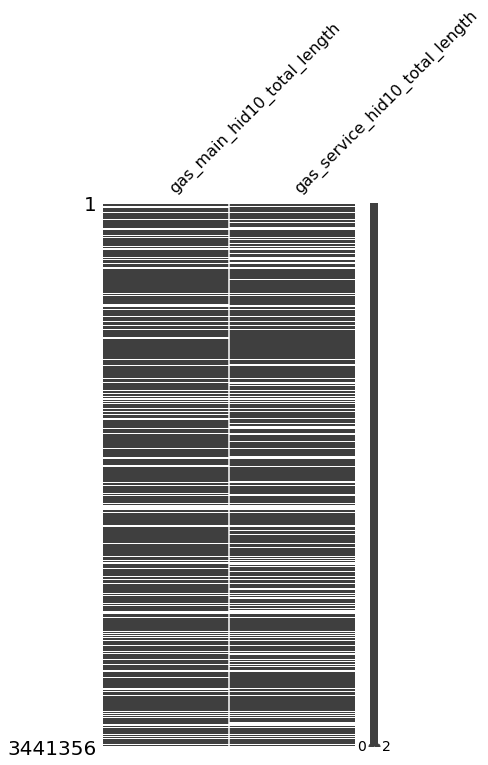

In [11]:
mno.matrix(data_raw[['gas_main_hid10_total_length', 'gas_service_hid10_total_length']], figsize = (5, 10))

Missing values are randomly distributed. 

In [12]:
data = data_raw.copy()

In [13]:
# some feature engineering on datetime
data['ticket_month'] = data['ticket_datetime'].dt.month
data['ticket_day_of_week'] = data['ticket_datetime'].dt.dayofweek

time_columns = ['ticket_month', 'ticket_day_of_week']
work_type_columns = data_raw.columns.tolist()[:67]
coordinates_columns = ['latitude', 'east_longitude']
hid10_columns = ['gas_main_hid10_total_length', 'gas_service_hid10_total_length']
y_column = 'has_damage'

In [14]:
# remove outliers (i removed this because we were losing too many positives by doing htis)
# data = data.loc[(data['east_longitude'] < -70) & (data['east_longitude'] > -85)]
# data = data.loc[(data['latitude'] < 42) & (data['latitude'] > 38)]
# data = data.loc[data['gas_service_hid10_total_length'] < 2000]

# make the data a bit more balanced
negatives = data.loc[data['has_damage'] == 0]
positives = data.loc[data['has_damage'] == 1]

negatives_downsampled = resample(negatives, 
                                 replace=True,     # sample with replacement
                                 n_samples=positives.shape[0]*9, 
                                 random_state=0) # reproducible results
 
data = pd.concat([negatives_downsampled, positives])
data.sort_values('ticket_datetime', inplace=True)

In [15]:
def plot_hist(data, colname, title):
    plt.figure(figsize=(20,5))
    sns.histplot(data[colname])
    plt.title(title, size="xx-large")
    
def create_barchart_with_fraction_of_positives(data, grouping_column, y_column, title, labels=None):
    grouped_data = data.groupby(grouping_column)[y_column]
    if labels is None:
        labels = grouped_data.count().reset_index()[grouping_column].tolist()
#     counts = grouped_data.count().tolist()
#     sums = grouped_data.sum().tolist()
    means = grouped_data.mean().tolist()
    
    plt.figure(figsize=(20,5))
    sns.barplot(x=labels, y=means, 
                color = 'blue', 
               )
    plt.ylabel("Fraction of events where damage occurs")
    plt.title("Fraction of events when damage occurs, by {}".format(title))
    
def time_series_train_test_split(X, y, test_size=0.33):
    cutoff = int(X.shape[0] * test_size)
    return X[:cutoff], X[cutoff:], y[:cutoff], y[cutoff:]

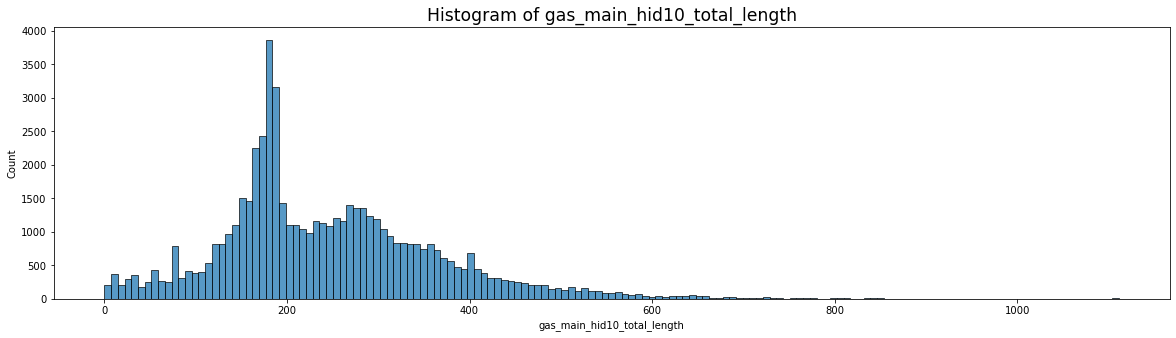

In [16]:
plot_hist(data, hid10_columns[0], "Histogram of {}".format(hid10_columns[0]))

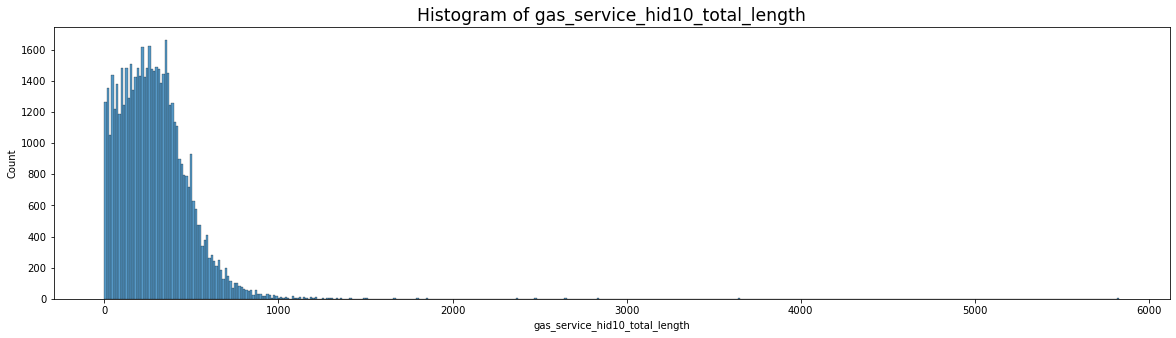

In [17]:
plot_hist(data, hid10_columns[1], "Histogram of {}".format(hid10_columns[1]))

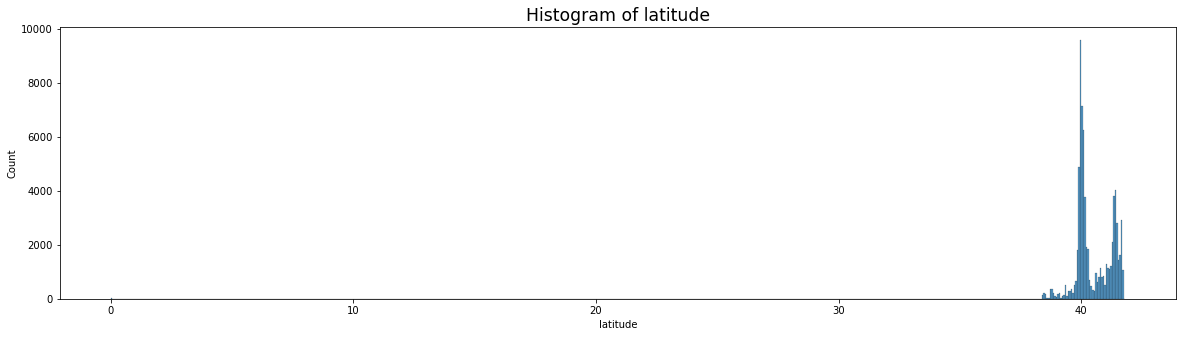

In [18]:
plot_hist(data, coordinates_columns[0], "Histogram of {}".format(coordinates_columns[0]))

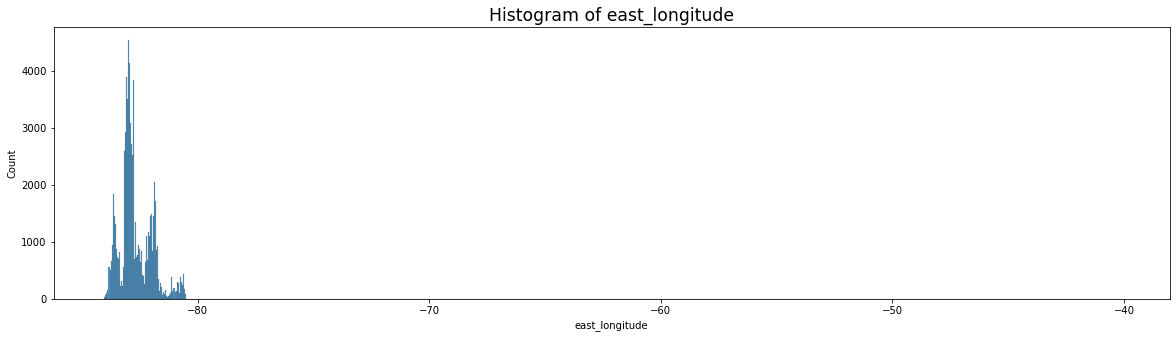

In [19]:
plot_hist(data, coordinates_columns[1], "Histogram of {}".format(coordinates_columns[1]))

In [20]:
eda_data = data.copy()

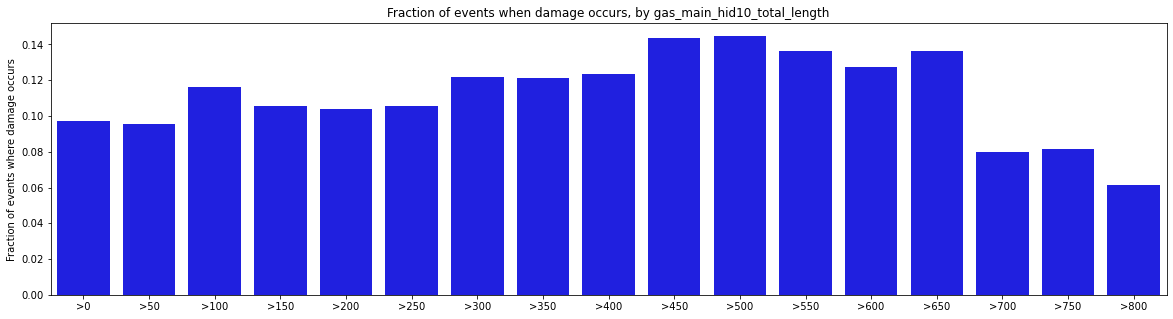

In [21]:
bins = np.arange(0, 801, 50)
eda_data[hid10_columns[0]+'_digitized'] = np.digitize(eda_data[hid10_columns[0]], bins=bins, right=True)
create_barchart_with_fraction_of_positives(eda_data, hid10_columns[0]+'_digitized', y_column, hid10_columns[0],
                                          labels=['>{}'.format(v) for v in bins])

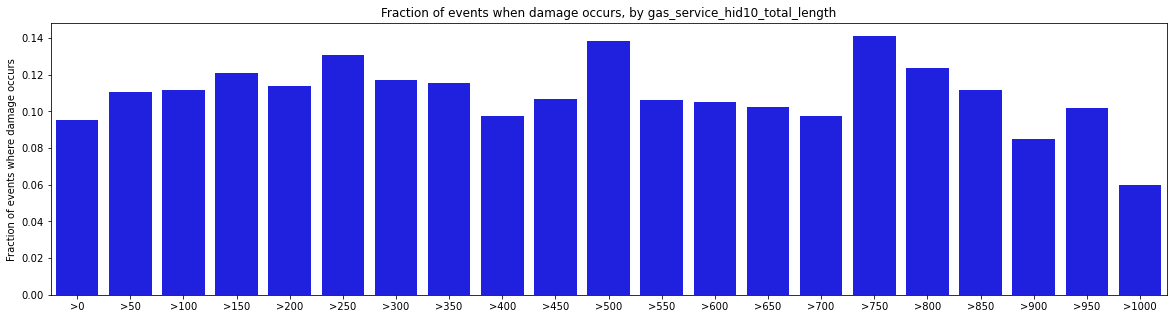

In [22]:
bins = np.arange(0, 1001, 50)
eda_data[hid10_columns[1]+'_digitized'] = np.digitize(eda_data[hid10_columns[1]], bins=bins, right=True)
create_barchart_with_fraction_of_positives(eda_data, hid10_columns[1]+'_digitized', y_column, hid10_columns[1],
                                          labels=['>{}'.format(v) for v in bins]
                                          )

In [23]:
# get a single column for work type, with ordinal values
for i, col in enumerate(work_type_columns[1:]):
    data.loc[:, col] = data.loc[:, col] * (i+1)
data['work_type_ordinal'] = data[work_type_columns].sum(axis=1)
data.loc[data[work_type_columns[0]] == 1, 'work_type_ordinal'] = 0

data.drop(work_type_columns, axis=1, inplace=True)

In [24]:
data.head()

,ticket_datetime,latitude,east_longitude,gas_main_hid10_total_length,gas_service_hid10_total_length,has_damage,ticket_month,ticket_day_of_week,work_type_ordinal
1947699,2015-01-01,41.448149,-82.188000,186.260828,368.729045,1,1,3,66
2675252,2015-01-02,39.771988,-82.448352,NaN,NaN,0,1,4,45
1827059,2015-01-02,39.923271,-82.971373,184.811957,26.421515,1,1,4,55
1983602,2015-01-02,40.764904,-82.499214,NaN,112.575348,0,1,4,66
3258928,2015-01-02,41.502603,-82.029225,379.077963,231.039580,1,1,4,8


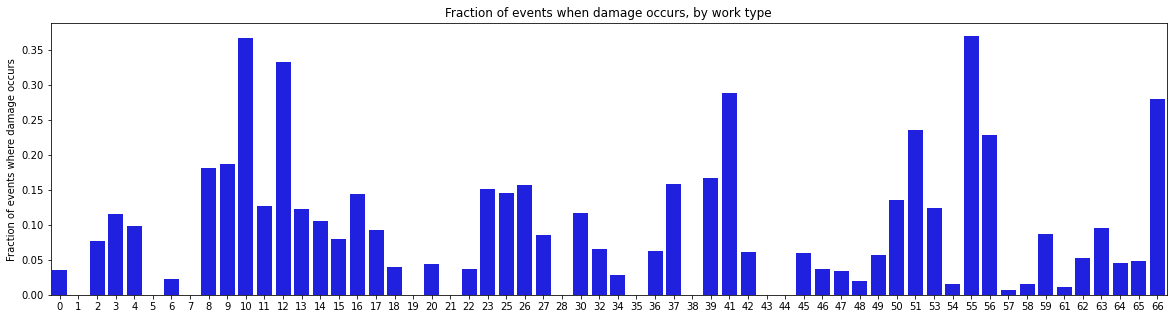

In [25]:
create_barchart_with_fraction_of_positives(data, 'work_type_ordinal', y_column, 'work type')

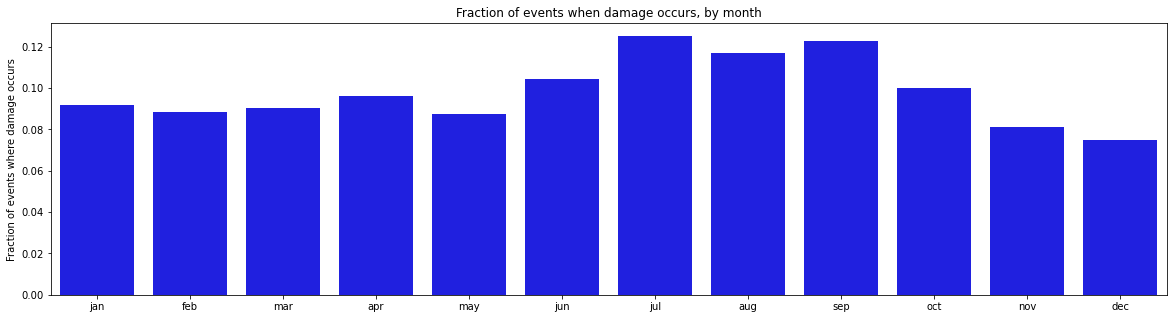

In [26]:
create_barchart_with_fraction_of_positives(data, time_columns[0], y_column, 'month', 
                                           labels=['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'])

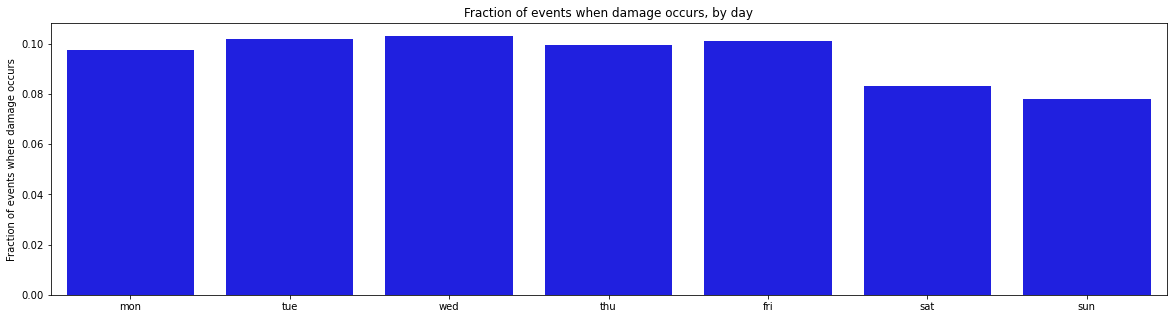

In [27]:
create_barchart_with_fraction_of_positives(data, time_columns[1], y_column, 'day', 
                                           labels=['mon', 'tue', 'wed', 'thu', 'fri', 'sat', 'sun'])

In [ ]:
# plot_hist(data, time_columns[0], "Histogram of {}".format(time_columns[0]))

# plot_hist(data, time_columns[1], "Histogram of {}".format(time_columns[1]))

# plot_hist(positives, time_columns[0], "Histogram of {}".format(time_columns[0]))

# plot_hist(positives, time_columns[1], "Histogram of {}".format(time_columns[1]))

[]

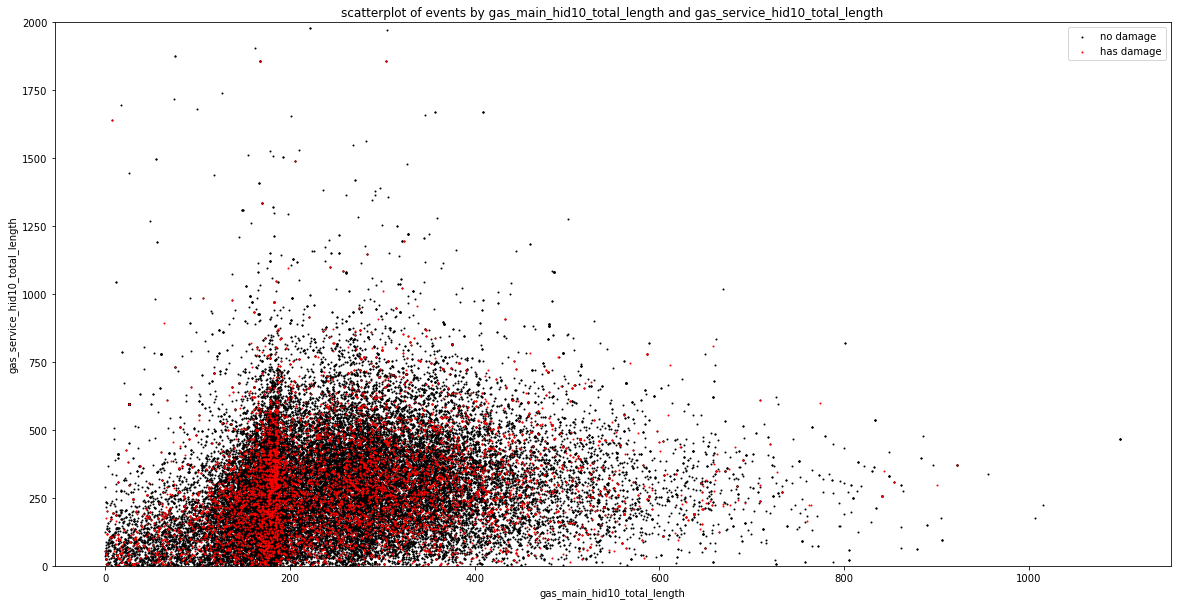

In [28]:
plt.figure(figsize=(20,10))
plt.scatter(negatives_downsampled[hid10_columns[0]],
           negatives_downsampled[hid10_columns[1]],
           c='black',
            label='no damage',
           s=1)
plt.scatter(positives[hid10_columns[0]],
           positives[hid10_columns[1]],
           c='red',
            label='has damage',
           s=1)
plt.ylim((0, 2000))
plt.title("scatterplot of events by {} and {}".format(hid10_columns[0], hid10_columns[1]))
plt.xlabel(hid10_columns[0])
plt.ylabel(hid10_columns[1])
plt.legend()
plt.plot()

[]

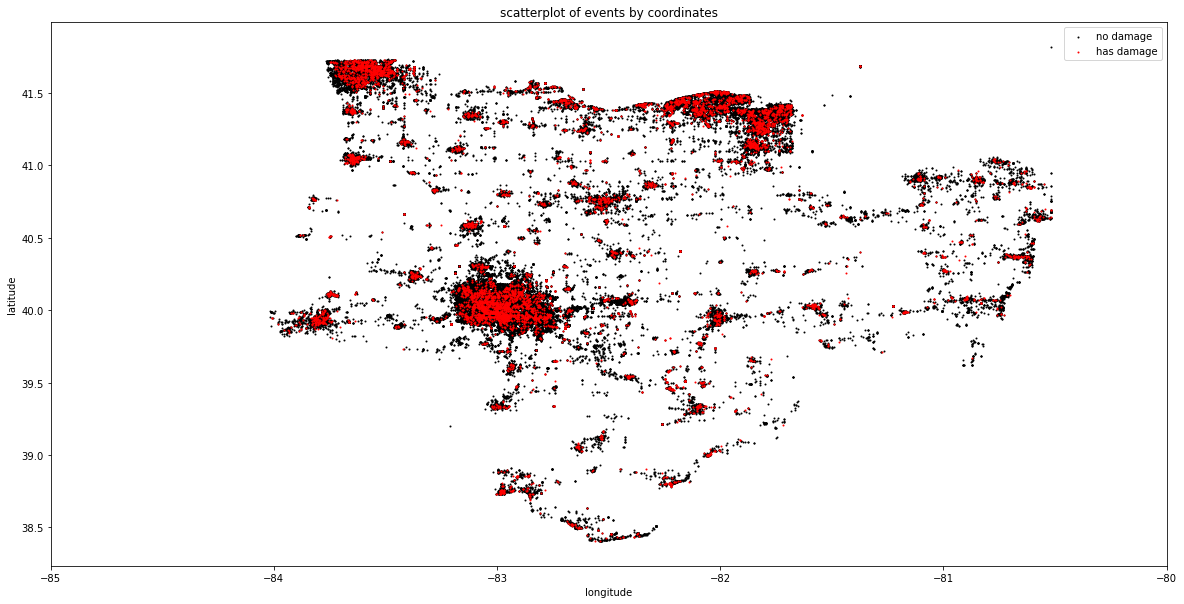

In [29]:
plt.figure(figsize=(20,10))
plt.scatter(negatives_downsampled['east_longitude'],
           negatives_downsampled['latitude'],
           c='black',
            label='no damage',
           s=1)
plt.scatter(positives['east_longitude'],
           positives['latitude'],
           c='red',
            label='has damage',
           s=1)
plt.xlim((-85, -80))
plt.title("scatterplot of events by coordinates")
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.legend()
plt.plot()

In [112]:
# # import gmplot package
# import gmplot
  
# gmap3 = gmplot.GoogleMapPlotter(np.mean(positives['latitude']),
#                                 np.mean(positives['east_longitude']), 
#                                 13)
  
# # scatter method of map object 
# # scatter points on the google map
# # gmap3.scatter( latitude_list, longitude_list, 
# #                               size = 40, marker = False )
# gmap3.scatter(negatives_downsampled['latitude'],
#               negatives_downsampled['east_longitude'],
#               color='black',
#               size=1,
#              marker=False)
# gmap3.scatter(positives['latitude'],
#               positives['east_longitude'],
#               color='red',
#               size=1,
#              marker=False)
  
# gmap3.draw("events_map.html")

# using model

In [30]:
data['work_type_ordinal'] = data['work_type_ordinal'].astype(str)
work_type_columns = ['work_type_ordinal']

In [31]:
X = data[time_columns + coordinates_columns + work_type_columns + hid10_columns]
y = data[y_column]

In [32]:
def time_series_train_test_split(X, y, test_size=0.33):
    cutoff = int(X.shape[0] * test_size)
    return X[:-cutoff], X[-cutoff:], y[:-cutoff], y[-cutoff:]

X_train, X_test, y_train, y_test = time_series_train_test_split(X, y, test_size=0.33)

In [33]:
X_train.shape

(49848, 7)

In [34]:
X_test.shape

(24552, 7)

In [35]:
# performes RandomizedSearch for tuning hyperparameters of our model, prints model performance, and returns best model
def perform_hyperparameter_tuning(X_train, y_train, X_test, y_test, 
                                  pipeline, 
                                  hyperparameters_to_tune, 
                                  n_iter, cv):
    optimizer = RandomizedSearchCV(pipeline, 
                                   hyperparameters_to_tune, 
                                   n_iter=n_iter, 
#                                    scoring='f1', 
                                   scoring='recall', 
                                   cv=cv, 
                                   verbose=2, 
                                   n_jobs=-1)
    results = optimizer.fit(X_train, y_train)
    print("Best combination of hyperparameters:\n", optimizer.best_params_)
    yhat_train = optimizer.predict(X_train)
    print("\nTrain classification report:\n", classification_report(y_train, yhat_train))
    yhat_test = optimizer.predict(X_test)
    print("\nTest classification report:\n", classification_report(y_test, yhat_test))
    return optimizer.best_estimator_

def get_scores(model, X, y):
    yhat = model.predict(X)
    print("classification_report:\n", classification_report(y, yhat))
    print("confusion_matrix:\n", confusion_matrix(y, yhat))
    print("accuracy_score: ", accuracy_score(y, yhat))
    print("balanced_accuracy_score: ", balanced_accuracy_score(y, yhat))
    print("precision_score: ", precision_score(y, yhat))
    print("recall_score: ", recall_score(y, yhat))
    print("f1_score: ", f1_score(y, yhat))

Since we are using tree based models, we don't need to scale our continuous features

### decision tree

In [36]:
pipeline = Pipeline([
    ('column_transformer', ColumnTransformer(
        [('categorical', BinaryEncoder(return_df=False), work_type_columns)],
        remainder='passthrough')
    ),
    ('imputer', IterativeImputer()),
    ('estimator', DecisionTreeClassifier(class_weight={0: 1, 1: 9}))
])
hyperparameters_to_tune = {
#     'imputer__estimator': [None, DecisionTreeRegressor()], 
    'estimator__max_depth': np.arange(1, 10, 1),
    'estimator__min_samples_split': np.arange(2, 50, 1),
    'estimator__min_samples_leaf': np.arange(1, 50, 1),
}

optimized_model = perform_hyperparameter_tuning(X_train, y_train, X_test, y_test,
                                                pipeline, 
                                                hyperparameters_to_tune, 
                                                n_iter=5, cv=3)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


C:\Users\amol.a.mane\AppData\Local\Continuum\anaconda3\envs\obk\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Best combination of hyperparameters:
 {'estimator__min_samples_split': 13, 'estimator__min_samples_leaf': 8, 'estimator__max_depth': 4}

Train classification report:
               precision    recall  f1-score   support

           0       0.96      0.72      0.83     44723
           1       0.23      0.72      0.35      5125

    accuracy                           0.72     49848
   macro avg       0.59      0.72      0.59     49848
weighted avg       0.88      0.72      0.78     49848


Test classification report:
               precision    recall  f1-score   support

           0       0.96      0.71      0.82     22237
           1       0.20      0.70      0.31      2315

    accuracy                           0.71     24552
   macro avg       0.58      0.70      0.56     24552
weighted avg       0.89      0.71      0.77     24552



In [38]:
pipeline = Pipeline([
    ('column_transformer', ColumnTransformer(
        [('categorical', BinaryEncoder(return_df=False), work_type_columns)],
        remainder='passthrough')
    ),
    ('imputer', IterativeImputer(DecisionTreeRegressor())),
    ('estimator', DecisionTreeClassifier(class_weight={0: 1, 1: 9},
                                         max_depth=5,
                                         min_samples_split=40,
                                         min_samples_leaf=29))
])

pipeline.fit(X_train, y_train)

print("Train***********************")
get_scores(pipeline, X_train, y_train)

print("\n\nTest***********************")
get_scores(pipeline, X_test, y_test)

C:\Users\amol.a.mane\AppData\Local\Continuum\anaconda3\envs\obk\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\Users\amol.a.mane\AppData\Local\Continuum\anaconda3\envs\obk\lib\site-packages\sklearn\impute\_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


Train***********************
classification_report:
               precision    recall  f1-score   support

           0       0.96      0.68      0.80     44723
           1       0.22      0.77      0.34      5125

    accuracy                           0.69     49848
   macro avg       0.59      0.73      0.57     49848
weighted avg       0.89      0.69      0.75     49848

confusion_matrix:
 [[30561 14162]
 [ 1166  3959]]
accuracy_score:  0.6925052158562028
balanced_accuracy_score:  0.7279137367524648
precision_score:  0.2184758015562055
recall_score:  0.7724878048780488
f1_score:  0.3406177406865697


Test***********************
classification_report:
               precision    recall  f1-score   support

           0       0.96      0.66      0.78     22237
           1       0.19      0.77      0.30      2315

    accuracy                           0.67     24552
   macro avg       0.58      0.71      0.54     24552
weighted avg       0.89      0.67      0.74     24552

confusi

### randomforest

In [17]:
# pipeline = Pipeline([
#     ('imputer', IterativeImputer()),
#     ('estimator', RandomForestClassifier(class_weight={0: 1, 1: 9}))
# ])

# pipeline.fit(X_train, y_train)

# get_scores(pipeline, X_train, y_train)

# get_scores(pipeline, X_test, y_test)